In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time
from itertools import product

# Initial Setup

In [4]:
# ===============================
# 1) Load & Prepare Data
# ===============================

df = pd.read_csv("titik_semprotan.csv")

point_ids = df["id"].tolist()
xy = df[["x", "y"]].values

# mapping id → index (dalam file)
raw_index = {pid: i for i, pid in enumerate(point_ids)}

# unique ordered list (buang duplikat, jaga urutan)
nodes = list(dict.fromkeys(point_ids))
N = len(nodes)


# ===============================
# 2) Build Coordinate Matrix
# ===============================

coords = np.array([xy[raw_index[n]] for n in nodes], dtype=np.float64)


# ===============================
# 3) Distance Matrix (Vectorized)
# ===============================

# matrix selisih koordinat shape (N, N, 2)
diff = coords[:, None, :] - coords[None, :, :]

# √(dx² + dy²)
dist_matrix = np.sqrt((diff ** 2).sum(axis=2))
np.fill_diagonal(dist_matrix, 0.0)

# mapping id → index (dalam dist_matrix)
node_index = {node_id: i for i, node_id in enumerate(nodes)}


# ===============================
# 4) Utility: Total Route Distance
# ===============================

def total_distance(route):
    """Hitung total jarak perjalanan (perimeter) dari urutan node."""
    L = len(route)
    if L < 2:
        return 0.0

    # ambil indeks dist_matrix
    idxs = [node_index[n] for n in route]

    # jumlahkan per edge
    d = sum(dist_matrix[idxs[i], idxs[i+1]] for i in range(L - 1))

    # kembali ke titik awal
    d += dist_matrix[idxs[-1], idxs[0]]

    return float(d)

# K Clustering

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# ===============================
# 1) Elbow Analysis (Inertia + Silhouette)
# ===============================

def elbow_analysis(
    coords,
    k_min=1,
    k_max=10,
    random_state=42,
    n_init=10,
    show_plot=True
):
    """Lakukan analisis elbow dan silhouette score untuk mencari jumlah cluster optimal."""

    max_k = min(k_max, len(coords))
    k_values = list(range(k_min, max_k + 1))

    inertias = []
    silhouettes = []

    # ------ Fit KMeans untuk setiap K ------
    for k in k_values:
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        labels = km.fit_predict(coords)

        inertias.append(km.inertia_)

        # silhouette hanya valid jika k >= 2
        silhouettes.append(
            silhouette_score(coords, labels) if k >= 2 else np.nan
        )

    # ------ Cari K heuristik: penurunan inertia terbesar ------
    best_k = k_values[0]
    if len(k_values) >= 3:
        drops = np.diff(inertias) * -1            # negatif karena inertia menurun
        rel_drops = drops / np.maximum(inertias[:-1], 1e-9)
        best_k = k_values[np.argmax(rel_drops) + 1]

    # ------ Plot (opsional) ------
    if show_plot:
        fig, ax1 = plt.subplots()

        # inertia
        ax1.plot(k_values, inertias, marker='o')
        ax1.set_xlabel("Jumlah cluster (K)")
        ax1.set_ylabel("Inertia (SSE)")
        ax1.set_title("Elbow Method")

        # mark best_k
        if best_k in k_values:
            yb = inertias[k_values.index(best_k)]
            ax1.scatter(best_k, yb, s=90)
            ax1.annotate(
                f"K terbaik (heuristik) = {best_k}",
                xy=(best_k, yb),
                xytext=(5, 5),
                textcoords="offset points"
            )

        # silhouette
        ax2 = ax1.twinx()
        ax2.plot(k_values, silhouettes, marker='x', linestyle='--')
        ax2.set_ylabel("Silhouette Score")

        plt.tight_layout()
        plt.show()

    return {
        "k_values": k_values,
        "inertias": inertias,
        "silhouettes": silhouettes,
        "best_k": best_k,
    }


# ===============================
# 2) Run KMeans
# ===============================

def run_kmeans(coords, nodes, k, random_state=42, n_init=10):
    """Jalankan KMeans dan mengembalikan labels, clusters (dict), dan centroids."""

    if not (1 <= k <= len(coords)):
        raise ValueError("k harus di antara 1 dan jumlah titik.")

    km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
    labels = km.fit_predict(coords)
    centroids = km.cluster_centers_

    # mapping cluster_id → list of node_ids
    clusters = {i: [] for i in range(k)}
    for node_id, lab in zip(nodes, labels):
        clusters[int(lab)].append(node_id)

    return labels, clusters, centroids


# ===============================
# 3) Visualisasi Cluster
# ===============================

def plot_clusters(coords, labels, centroids=None):
    """Scatter plot kluster dengan warna berbeda."""
    labels = np.asarray(labels)
    k = labels.max() + 1

    for cid in range(k):
        pts = coords[labels == cid]
        plt.scatter(pts[:, 0], pts[:, 1], label=f"Cluster {cid}", s=20)

    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='^', s=120)

    plt.legend()
    plt.title("K-Means Clusters")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()


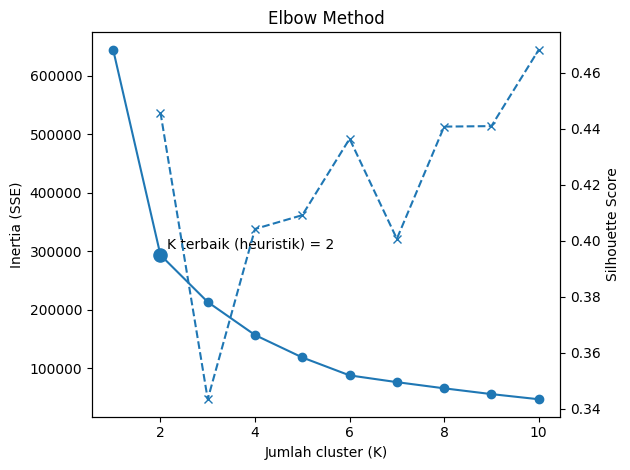

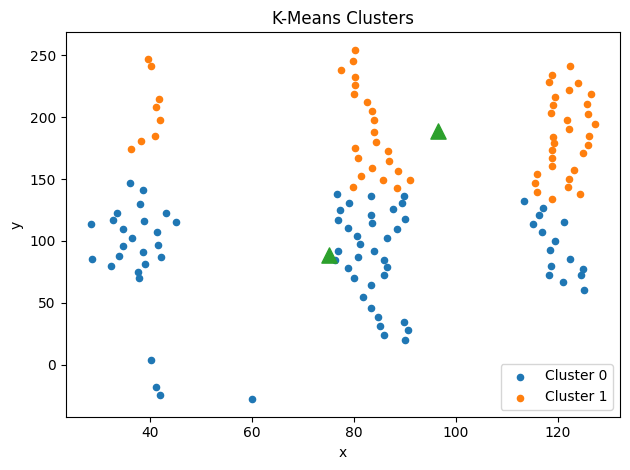

In [6]:
info = elbow_analysis(coords, k_min=1, k_max=10, show_plot=True)
best_k = info["best_k"]

labels, clusters, centroids = run_kmeans(coords, nodes, best_k)

plot_clusters(coords, labels, centroids)

# Ortools for Benchmarking

In [7]:
from ortools.constraint_solver import routing_enums_pb2, pywrapcp
import random

SCALE = 1000  # faktor skala untuk mengubah jarak float → integer

# ===============================
# 1) Distance Matrix Helper
# ===============================

def build_scaled_distance_matrix(node_ids, use_precomputed=True, scale=SCALE):
    """
    Bangun matrix jarak (integer) untuk OR-Tools Routing:
      - node_ids: list ID node (misal: [101, 102, 103, ...])
      - use_precomputed: True -> pakai dist_matrix & node_index global
                         False -> pakai get_weight(i, j)
      - scale: faktor skala (default 1000)

    Mengembalikan: matrix jarak integer shape (N, N)
    """
    n = len(node_ids)
    matrix = [[0] * n for _ in range(n)]

    for i, a in enumerate(node_ids):
        ia = node_index[a]
        for j, b in enumerate(node_ids):
            ib = node_index[b]
            d = dist_matrix[ia, ib]
            matrix[i][j] = int(round(scale * float(d)))

    return matrix

# ===============================
# 2) Label → Vehicle Mapping
# ===============================

def remap_cluster_labels_to_vehicles(nodes, labels, start_ids):
    """
    Pastikan indeks vehicle 0..K-1 konsisten dengan urutan start_ids.

    nodes   : list node ID (sejajar dengan labels)
    labels  : label cluster untuk tiap node (len == len(nodes))
    start_ids : list node ID yang dipakai sebagai start tiap vehicle

    Return:
      - labels_remapped: list vehicle_id untuk tiap node (0..K-1)
      - label_to_vehicle: dict {cluster_label_asal -> vehicle_id}
    """
    # ambil label cluster untuk node yang jadi start tiap vehicle
    cluster_from_starts = [labels[nodes.index(sid)] for sid in start_ids]

    label_to_vehicle = {
        cluster_label: vehicle_id
        for vehicle_id, cluster_label in enumerate(cluster_from_starts)
    }

    # remap seluruh labels ke vehicle_id
    labels_remapped = [label_to_vehicle[lbl] for lbl in labels]

    return labels_remapped, label_to_vehicle


# ===============================
# 3) Data Model VRP Tercluster
# ===============================

def create_clustered_vrp_data(
    nodes,
    labels,
    start_ids,
    end_ids=None,
    scale=SCALE,
    use_precomputed=True,
):
    """
    Buat data model untuk OR-Tools VRP berbasis cluster.

    nodes      : list node ID (urutan global)
    labels     : list label cluster (sejajar dengan nodes)
    start_ids  : list node ID titik start per vehicle (panjang K)
    end_ids    : list node ID titik end per vehicle (default = start_ids)
    scale      : faktor skala jarak
    use_precomputed : True → pakai dist_matrix & node_index global

    Return dict:
      {
        "distance_matrix": ...,
        "num_vehicles": K,
        "starts": [idx_start],
        "ends": [idx_end],
        "node_allowed_vehicles": {node_idx: [vehicle_id]},
        "nodes": nodes,
        "scale": scale,
      }
    """
    assert len(nodes) == len(labels), "labels harus sejajar dengan nodes"

    k_vehicles = len(start_ids)
    if end_ids is None:
        end_ids = start_ids[:]

    assert len(end_ids) == k_vehicles, "end_ids harus sama panjang dengan start_ids"

    # Remap label cluster → vehicle index berdasarkan start_ids
    labels_remapped, label_to_vehicle = remap_cluster_labels_to_vehicles(
        nodes, labels, start_ids
    )

    # Validasi start/end ada di nodes
    for s_id, e_id in zip(start_ids, end_ids):
        assert s_id in nodes and e_id in nodes, "start/end harus ada di nodes"

    # Bangun distance matrix scaled
    distance_matrix = build_scaled_distance_matrix(
        nodes, use_precomputed=use_precomputed, scale=scale
    )

    # Node hanya boleh dikunjungi vehicle sesuai cluster-nya
    node_allowed_vehicles = {
        i: [int(labels_remapped[i])] for i in range(len(nodes))
    }

    # Konversi start/end ke index internal (0..N-1)
    starts_idx = [nodes.index(x) for x in start_ids]
    ends_idx = [nodes.index(x) for x in end_ids]

    return {
        "distance_matrix": distance_matrix,
        "num_vehicles": k_vehicles,
        "starts": starts_idx,
        "ends": ends_idx,
        "node_allowed_vehicles": node_allowed_vehicles,
        "nodes": nodes,
        "scale": scale,
    }


# ===============================
# 4) Cost Helper
# ===============================

def route_cost_from_matrix(route_node_indices, distance_matrix):
    """Hitung cost (integer scaled) sepanjang rute (dari list index node)."""
    cost = 0
    for a, b in zip(route_node_indices[:-1], route_node_indices[1:]):
        cost += distance_matrix[a][b]
    return cost


# ===============================
# 5) Solver VRP Clustered
# ===============================

def solve_vrp_clustered(
    nodes,
    labels,
    start_ids,
    end_ids=None,
    timeout_s=60,
    first_strategy="PATH_CHEAPEST_ARC",
    metaheuristic="GUIDED_LOCAL_SEARCH",
    use_precomputed=True,
    scale=SCALE,
):
    """
    Solve VRP dengan constraint cluster:
      - Tiap node hanya boleh dilayani oleh vehicle sesuai cluster-nya.
      - Start/end tiap vehicle sudah ditentukan.

    Return:
      - routes_ids: list rute per vehicle (list of node IDs)
      - per_vehicle_costs: list biaya per vehicle (float, unscaled)
      - total_cost: total biaya (float, unscaled)
    """
    data = create_clustered_vrp_data(
        nodes,
        labels,
        start_ids,
        end_ids=end_ids,
        scale=scale,
        use_precomputed=use_precomputed,
    )

    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]),
        data["num_vehicles"],
        data["starts"],
        data["ends"],
    )
    routing = pywrapcp.RoutingModel(manager)

    # ---- Cost callback ----
    def distance_callback(from_index, to_index):
        f = manager.IndexToNode(from_index)
        t = manager.IndexToNode(to_index)
        return data["distance_matrix"][f][t]

    transit_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_idx)

    # ---- Lock node → vehicle sesuai cluster ----
    for node_id in range(len(nodes)):
        index = manager.NodeToIndex(node_id)
        routing.SetAllowedVehiclesForIndex(
            data["node_allowed_vehicles"][node_id],
            index
        )

    # ---- Search parameters ----
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.time_limit.seconds = int(timeout_s)
    search_parameters.first_solution_strategy = getattr(
        routing_enums_pb2.FirstSolutionStrategy,
        first_strategy,
    )
    search_parameters.local_search_metaheuristic = getattr(
        routing_enums_pb2.LocalSearchMetaheuristic,
        metaheuristic,
    )

    solution = routing.SolveWithParameters(search_parameters)
    if not solution:
        print("No solution found!")
        return None, [], float("inf")

    routes_ids = []
    per_vehicle_costs = []
    total_scaled_cost = 0

    # ---- Extract solution per vehicle ----
    for v in range(data["num_vehicles"]):
        index = routing.Start(v)
        route_idx = []

        while not routing.IsEnd(index):
            route_idx.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route_idx.append(manager.IndexToNode(index))  # tambahkan end

        # index → node ID
        route_ids = [data["nodes"][i] for i in route_idx]
        routes_ids.append(route_ids)

        # cost dari matrix (scaled)
        c_scaled = route_cost_from_matrix(route_idx, data["distance_matrix"])
        total_scaled_cost += c_scaled
        per_vehicle_costs.append(c_scaled / float(data["scale"]))

    total_cost = total_scaled_cost / float(data["scale"])
    return routes_ids, per_vehicle_costs, total_cost


# ===============================
# 6) Random Starts per Cluster
# ===============================

def solve_vrp_clustered_random_starts(
    nodes,
    labels,
    timeout_s=60,
    use_precomputed=True,
    seed=None,
    round_trip=True,
    scale=SCALE,
):
    """
    Pilih start node secara acak di setiap cluster, lalu solve VRP.

    Return dict:
      {
        "starts": list start ID per vehicle/cluster,
        "routes": list rute (list of node IDs) per vehicle,
        "per_costs": biaya per vehicle (float),
        "total_cost": total biaya (float)
      }
    """
    rng = random.Random(seed)
    k_clusters = int(max(labels)) + 1

    # kumpulkan node per cluster
    clusters = {c: [] for c in range(k_clusters)}
    for n_id, lab in zip(nodes, labels):
        clusters[int(lab)].append(n_id)

    # pilih start random per cluster
    start_ids = [rng.choice(clusters[c]) for c in range(k_clusters)]

    # end: round trip ke start (atau random lain kalau diinginkan)
    if round_trip:
        end_ids = start_ids
    else:
        end_ids = [rng.choice(clusters[c]) for c in range(k_clusters)]

    routes, per_costs, total_cost = solve_vrp_clustered(
        nodes,
        labels,
        start_ids,
        end_ids=end_ids,
        timeout_s=timeout_s,
        use_precomputed=use_precomputed,
        scale=scale,
    )

    return {
        "starts": start_ids,
        "routes": routes,
        "per_costs": per_costs,
        "total_cost": total_cost,
    }


In [8]:
res = solve_vrp_clustered_random_starts(nodes, labels, timeout_s=20)
print("Start per kluster:", res["starts"])
print("Biaya per kluster:", res["per_costs"])
print("Total cost:", res["total_cost"])

for i, r in enumerate(res["routes"], 1):
    print(f"Rute kendaraan {i}:", r)

Start per kluster: [11, 75]
Biaya per kluster: [735.655, 574.145]
Total cost: 1309.8
Rute kendaraan 1: [11, 103, 42, 4, 95, 133, 111, 63, 23, 107, 34, 72, 40, 81, 37, 96, 112, 132, 62, 93, 15, 106, 110, 54, 29, 52, 117, 10, 80, 51, 27, 59, 125, 82, 3, 90, 114, 78, 38, 53, 135, 8, 84, 69, 116, 18, 58, 128, 44, 108, 41, 6, 85, 16, 60, 20, 77, 88, 76, 47, 115, 30, 55, 71, 1, 130, 101, 50, 43, 123, 67, 129, 21, 124, 26, 11]
Rute kendaraan 2: [75, 119, 98, 131, 13, 89, 33, 100, 126, 61, 45, 46, 19, 118, 68, 109, 121, 87, 28, 122, 73, 57, 134, 14, 102, 31, 83, 65, 7, 86, 22, 79, 35, 17, 56, 99, 9, 49, 94, 24, 105, 36, 91, 5, 97, 74, 39, 104, 113, 64, 25, 120, 70, 12, 92, 32, 66, 127, 2, 48, 75]


In [86]:
def get_node_xy(node_id, coords, node_index):
    """
    Ambil koordinat (x, y) untuk sebuah node_id.
    - coords: array Nx2, sejajar dengan urutan `nodes`
    - node_index: dict {node_id -> index di coords}
    """
    i = node_index[node_id]
    return coords[i, 0], coords[i, 1]


def plot_vrp_routes(
    routes,
    coords,
    node_index,
    starts=None,
    ends=None,
    show_ids=False,
    title="VRP routes",
    close_loop=False
):
    """
    Visualisasi rute VRP:
      - routes : list of list node_id, satu list per vehicle
      - coords : array koordinat (N, 2), urutannya sejajar dengan `nodes`
      - node_index : dict {node_id -> index di coords}
      - starts : optional list start node_id per vehicle (default: route[0])
      - ends   : optional list end node_id per vehicle (default: route[-1])
      - show_ids : kalau True, tulis ID di tiap titik
    """

    fig, ax = plt.subplots(figsize=(7, 6))

    # semua titik sebagai background
    ax.scatter(coords[:, 0], coords[:, 1], s=10, alpha=0.3, label="_all_points_bg")

    # gambar tiap rute vehicle
    for v, route in enumerate(routes):
        if not route:
            continue

        # koordinat sepanjang rute (termasuk end)
        xs, ys = zip(*(get_node_xy(nid, coords, node_index) for nid in route))

        # kalau diminta loop: tutup ke node pertama
        if close_loop and len(route) > 1:
            x0, y0 = get_node_xy(route[0], coords, node_index)
            xs = list(xs) + [x0]
            ys = list(ys) + [y0]

        # garis rute
        ax.plot(xs, ys, marker="o", linewidth=2, markersize=4, label=f"Vehicle {v}")

        # tentukan start & end
        start_id = starts[v] if starts is not None else route[0]
        end_id   = ends[v]   if ends   is not None else route[-1]

        sx, sy = get_node_xy(start_id, coords, node_index)
        ex, ey = get_node_xy(end_id,   coords, node_index)

        # start: bintang
        ax.scatter(
            [sx], [sy],
            marker="*",
            s=180,
            edgecolor="k",
            linewidths=0.8,
            zorder=5,
            label=f"_start_{v}",  # diawali "_" supaya tidak tampil di legend
        )

        # # end: kotak (kalau beda dari start)
        # if end_id != start_id:
        #     ax.scatter(
        #         [ex], [ey],
        #         marker="s",
        #         s=90,
        #         edgecolor="k",
        #         linewidths=0.8,
        #         zorder=5,
        #         label=f"_end_{v}",
        #     )

        # optional: tulis ID
        if show_ids:
            for nid in route:
                x, y = get_node_xy(nid, coords, node_index)
                ax.text(x, y, str(nid), fontsize=8, ha="right", va="bottom")

    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    ax.axis("equal")
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

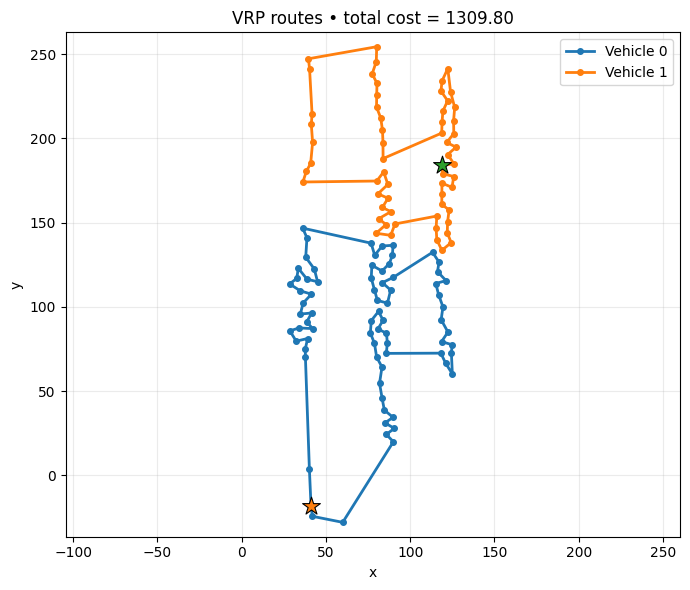

In [10]:
plot_vrp_routes(
    routes=res["routes"],
    coords=coords,
    node_index=node_index,
    starts=res["starts"],
    ends=None,  # None -> otomatis end = node terakhir di route
    show_ids=False,
    title=f"VRP routes • total cost = {res['total_cost']:.2f}"
)

In [11]:
# def plot_clustered_routes_matplotlib(cluster_routes, show_ids=False, title=None):
#     fig, ax = plt.subplots(figsize=(7, 6))

#     # background semua titik
#     ax.scatter(coords[:,0], coords[:,1], s=10, alpha=0.25, label="_all_points_bg")

#     for c, route in enumerate(cluster_routes):
#         if not route:
#             continue

#         # urutan titik termasuk menutup ke awal (jika L>=2)
#         xs, ys = [], []
#         for nid in route:
#             x, y = _xy_of(nid)
#             xs.append(x); ys.append(y)
#         if len(route) >= 2:
#             x0, y0 = _xy_of(route[0])
#             xs.append(x0); ys.append(y0)

#         ax.plot(xs, ys, marker='o', linewidth=2, markersize=4, label=f"Cluster {c}")

#         # tandai start (node pertama di list)
#         sx, sy = _xy_of(route[0])
#         ax.scatter([sx],[sy], marker='*', s=160, edgecolor='k', linewidths=0.8, zorder=5, label=f"_start_{c}")

#         if show_ids:
#             for nid in route:
#                 x, y = _xy_of(nid)
#                 ax.text(x, y, str(nid), fontsize=8, ha='right', va='bottom')

#     if title is None:
#         title = "Lovebird (clustered) routes"
#     ax.set_title(title)
#     ax.set_xlabel("x"); ax.set_ylabel("y")
#     ax.legend()
#     ax.axis("equal")
#     ax.grid(True, alpha=0.25)
#     plt.tight_layout()
#     plt.show()

# Lovebird Initial Algorithm

In [12]:
# ===============================
# 1) Mutasi tur (operator Lovebird)
# ===============================

def swap_two(tour, i, j):
    """Tukar dua blok dalam sub-segmen [i:j] (versi 'split tengah' yang lama kamu pakai)."""
    new = tour[:]
    if j - i < 4:
        return interchange(new, i, j)

    mid = new[i:j+1]
    k = len(mid) // 2
    seg1 = mid[:k]
    seg2 = mid[k:]
    new[i:i+k] = seg2
    new[i+k:j+1] = seg1
    return new


def flip(tour, i, j):
    """2-OPT style: reverse sub-segmen [i:j]."""
    new = tour[:]
    new[i:j+1] = reversed(new[i:j+1])
    return new


def interchange(tour, i, j):
    """Swap sederhana: tukar posisi dua kota."""
    new = tour[:]
    new[i], new[j] = new[j], new[i]
    return new


def slide(tour, i, j):
    """Ambil kota di posisi i, sisipkan di posisi j."""
    new = tour[:]
    city = new.pop(i)
    new.insert(j, city)
    return new


def guided_swap(tour, i, j):
    """Flip lalu swap di ujung segmen: kombinasi eksploratif."""
    return interchange(flip(tour, i, j), i, j)


def scramble(tour, rng=None):
    """Acak total urutan tour."""
    if rng is None:
        rng = random
    new = tour[:]
    rng.shuffle(new)
    return new

In [13]:
# ===============================
# 2) Roulette wheel selection
# ===============================

def roulette_wheel(population, fitness, rng=None):
    """
    Pilih satu individu secara probabilistik (roulette wheel).
    fitness[i] proporsional dengan peluang kepilih.
    """
    if rng is None:
        rng = random

    total_fitness = sum(fitness)
    if total_fitness <= 0:
        # fallback: pilih random uniform
        return rng.choice(population)

    threshold = rng.uniform(0, total_fitness)
    cumsum = 0.0

    for indiv, fit in zip(population, fitness):
        cumsum += fit
        if cumsum >= threshold:
            return indiv

    return population[-1]  # fallback

In [14]:
# ===============================
# 3) Helper: mapping cluster -> list node
# ===============================

def _clusters_from_labels(nodes, labels):
    """
    Bangun dict cluster_id -> list node_id (urutan mengikuti `nodes`).
    """
    k_clusters = int(max(labels)) + 1
    clusters = {c: [] for c in range(k_clusters)}
    for n, lab in zip(nodes, labels):
        clusters[int(lab)].append(n)
    return clusters, k_clusters

In [15]:
def lovebird_algorithm_clustered(labels, nodes, maxGeneration, popSize, seed=None):
    """
    Lovebird GA versi clustered:
      - labels: label cluster untuk tiap node (sejajar dengan `nodes`)
      - nodes : list node_id (urutan global)
      - maxGeneration: jumlah generasi GA
      - popSize: ukuran populasi
      - seed: untuk reproduksibilitas (optional)

    Mengembalikan:
      - best_solution: list of routes per cluster (list of list node_id)
      - best_total_cost: total jarak semua cluster (float)
      - history: list best cost per generasi
      - per_cluster_costs: list cost per cluster pada solusi terbaik
    """

    # pakai RNG lokal supaya reproducible
    rng = random.Random(seed)
    EPS = 1e-12

    # akses jarak global yang sudah kita siapkan di awal
    dist = dist_matrix
    ix = node_index

    # --- 1) Bangun mapping cluster -> list node ---
    cluster_nodes, K = _clusters_from_labels(nodes, labels)

    # --- 2) Inisialisasi populasi: permutasi acak per cluster ---
    def random_individual():
        """Satu individu = list route per cluster."""
        indiv = []
        for c in range(K):
            route = cluster_nodes[c][:]
            rng.shuffle(route)
            indiv.append(route)
        return indiv

    population = [random_individual() for _ in range(popSize)]

    # biaya awal populasi
    pop_costs = [sum(total_distance(route) for route in indiv) for indiv in population]

    # best awal
    best_idx = min(range(popSize), key=lambda i: pop_costs[i])
    best_solution = [route[:] for route in population[best_idx]]
    best_total_cost = pop_costs[best_idx]
    history = [best_total_cost]

    # --- 3) Local search untuk satu route (cluster) ---
    def improve_route(route):
        """
        First-improvement local search:
        - dilakukan di atas lintasan circular
        - kombinasi SWAP node & 2-OPT (flip)
        Return: (route_baru, delta_cost_total)
        """
        Lr = len(route)
        if Lr <= 2:
            return route, 0.0

        improved_outer = True
        total_delta = 0.0

        while improved_outer:
            improved_outer = False

            # ---- SWAP circular ----
            made_swap = True
            while made_swap:
                made_swap = False
                if Lr <= 2:
                    break
                accepted = False

                i = 0
                while i < Lr - 1 and not accepted:
                    j = i + 1
                    while j < Lr and not accepted:
                        a_idx, c_idx = i, j

                        aL = route[(a_idx - 1) % Lr]
                        a  = route[a_idx]
                        b  = route[(a_idx + 1) % Lr]

                        cL = route[(c_idx - 1) % Lr]
                        c  = route[c_idx]
                        d  = route[(c_idx + 1) % Lr]

                        # cek adjacency (kasus beda formula)
                        adjacent = (
                            c_idx == a_idx + 1 or
                            (a_idx == 0 and c_idx == Lr - 1)
                        )

                        if adjacent:
                            if c_idx == a_idx + 1:
                                # ...aL - a - c - d...
                                old = (
                                    dist[ix[aL], ix[a]] +
                                    dist[ix[a], ix[c]] +
                                    dist[ix[c], ix[d]]
                                )
                                new = (
                                    dist[ix[aL], ix[c]] +
                                    dist[ix[c], ix[a]] +
                                    dist[ix[a], ix[d]]
                                )
                            else:
                                # ...cL - c - a - b...
                                old = (
                                    dist[ix[cL], ix[c]] +
                                    dist[ix[c], ix[a]] +
                                    dist[ix[a], ix[b]]
                                )
                                new = (
                                    dist[ix[cL], ix[a]] +
                                    dist[ix[a], ix[c]] +
                                    dist[ix[c], ix[b]]
                                )
                        else:
                            # general case: dua edge terpisah
                            old = (
                                dist[ix[aL], ix[a]] +
                                dist[ix[a], ix[b]] +
                                dist[ix[cL], ix[c]] +
                                dist[ix[c], ix[d]]
                            )
                            new = (
                                dist[ix[aL], ix[c]] +
                                dist[ix[c], ix[b]] +
                                dist[ix[cL], ix[a]] +
                                dist[ix[a], ix[d]]
                            )

                        delta = new - old
                        if delta < -EPS:
                            # terima swap
                            route[a_idx], route[c_idx] = route[c_idx], route[a_idx]
                            total_delta += delta
                            made_swap = True
                            improved_outer = True
                            accepted = True
                        else:
                            j += 1

                    if not accepted:
                        i += 1

                if made_swap:
                    break  # restart scan

            # ---- 2-OPT / FLIP circular ----
            made_flip = True
            while made_flip:
                made_flip = False
                if Lr <= 2:
                    break
                accepted = False

                i = 0
                while i < Lr - 1 and not accepted:
                    j = i + 1
                    while j < Lr and not accepted:
                        # skip flip seluruh route (tidak ada efek)
                        if i == 0 and j == Lr - 1:
                            j += 1
                            continue

                        ap = route[(i - 1) % Lr]
                        a  = route[i]
                        c  = route[j]
                        dn = route[(j + 1) % Lr]

                        old = dist[ix[ap], ix[a]] + dist[ix[c], ix[dn]]
                        new = dist[ix[ap], ix[c]] + dist[ix[a], ix[dn]]
                        delta = new - old

                        if delta < -EPS:
                            route[i:j+1] = reversed(route[i:j+1])
                            total_delta += delta
                            made_flip = True
                            improved_outer = True
                            accepted = True
                        else:
                            j += 1

                    if not accepted:
                        i += 1

                if made_flip:
                    break  # restart scan

        return route, total_delta

    # --- 4) GA loop ---
    for g in range(maxGeneration):
        # fitness = 1 / cost
        fitness = [1.0 / c if c > 0 else 1e9 for c in pop_costs]

        new_population = []
        new_costs = []

        for _ in range(popSize):
            # ------- selection: roulette -------
            parent = roulette_wheel(population, fitness, rng=rng)

            # copy parent (list of routes per cluster)
            individual = [route[:] for route in parent]

            # ------- mutation: pilih cluster acak, mutasi satu rute -------
            v = rng.randrange(K) if K > 0 else 0
            route = individual[v]
            L = len(route)

            if L > 1:
                if rng.random() < 0.9 and L >= 2:
                    i_idx, j_idx = sorted(rng.sample(range(L), 2))
                    op = rng.choice([1, 2, 3, 4, 5])
                    if op == 1:
                        route = swap_two(route, i_idx, j_idx)
                    elif op == 2:
                        route = flip(route, i_idx, j_idx)
                    elif op == 3:
                        route = interchange(route, i_idx, j_idx)
                    elif op == 4:
                        route = slide(route, i_idx, j_idx)
                    else:
                        route = guided_swap(route, i_idx, j_idx)
                else:
                    route = scramble(route, rng=rng)

                individual[v] = route

            # hitung biaya awal kandidat
            route_costs = [total_distance(r) for r in individual]
            total_cost = float(sum(route_costs))

            # ------- local search per cluster -------
            for c in range(K):
                before = individual[c]
                after, delta = improve_route(before)
                if delta != 0.0:
                    individual[c] = after
                    route_costs[c] += delta
                    total_cost += delta

            new_population.append(individual)
            new_costs.append(total_cost)

        # ------- elitism: simpan solusi terbaik -------
        gen_best_idx = min(range(popSize), key=lambda i: new_costs[i])
        if new_costs[gen_best_idx] < best_total_cost - EPS:
            best_total_cost = new_costs[gen_best_idx]
            best_solution = [r[:] for r in new_population[gen_best_idx]]

        population = new_population
        pop_costs = new_costs
        history.append(best_total_cost)

    # biaya per cluster untuk best_solution
    per_cluster_costs = [total_distance(r) for r in best_solution]
    best_total_cost = float(sum(per_cluster_costs))
    
    best_solution = [
        (r + [r[0]]) if len(r) > 0 else r
        for r in best_solution
    ]

    return best_solution, best_total_cost, history, per_cluster_costs

In [16]:
# labels = ...   # hasil KMeans, sejajar dengan nodes
best_sol_l, total_cost_l, hist_l, per_costs_l = lovebird_algorithm_clustered(
    labels, nodes, maxGeneration=10, popSize=10
)

print("Biaya per kluster:", per_costs_l)
print("Total biaya:", total_cost_l)
for i, r in enumerate(best_sol_l, 1):
    print(f"Rute kluster {i} (|r|={len(r)}):", r)

Biaya per kluster: [738.0968106072039, 577.8862399937198]
Total biaya: 1315.9830506009237
Rute kluster 1 (|r|=76): [1, 130, 101, 50, 43, 123, 67, 129, 21, 124, 26, 11, 103, 42, 4, 95, 133, 111, 63, 23, 107, 34, 72, 40, 81, 37, 62, 96, 132, 93, 15, 106, 110, 54, 29, 52, 117, 10, 80, 51, 27, 59, 125, 82, 3, 90, 114, 44, 128, 58, 78, 53, 135, 112, 8, 84, 38, 69, 18, 116, 41, 108, 6, 85, 16, 60, 20, 76, 47, 115, 30, 88, 77, 55, 71, 1]
Rute kluster 2 (|r|=61): [97, 31, 83, 102, 14, 134, 57, 73, 122, 87, 121, 28, 109, 19, 46, 45, 61, 126, 118, 68, 100, 33, 89, 13, 131, 98, 119, 75, 48, 2, 127, 66, 32, 92, 12, 70, 120, 25, 64, 113, 104, 39, 74, 5, 91, 36, 105, 24, 94, 49, 9, 99, 56, 17, 35, 79, 22, 86, 7, 65, 97]


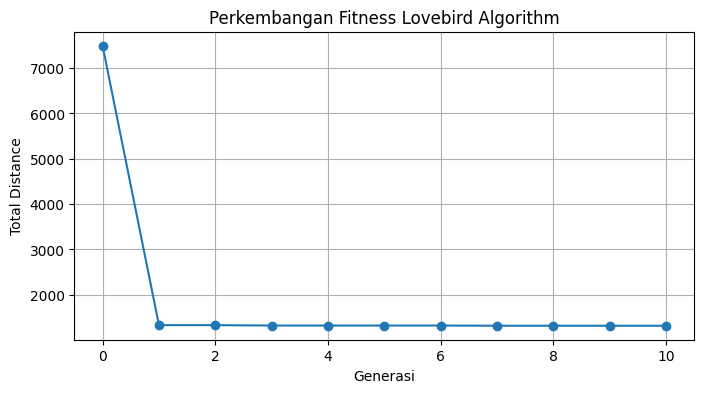

In [17]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_l, marker='o')
plt.title("Perkembangan Fitness Lovebird Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

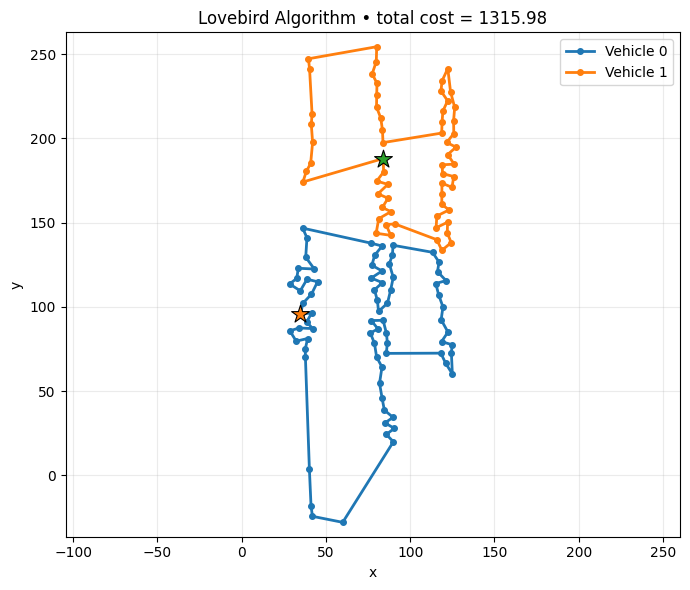

In [18]:
plot_vrp_routes(
    routes=best_sol_l,       # hasil Lovebird per cluster
    coords=coords,
    node_index=node_index,
    starts=[r[0] for r in best_sol_l],  # start = node pertama tiap cluster
    ends=None,
    show_ids=False,
    title=f"Lovebird Algorithm • total cost = {total_cost_l:.2f}",
    close_loop=True
)

In [83]:
route_test = [67, 123, 43, 50, 101, 130, 1, 71, 55, 30, 115, 47, 88, 77, 20, 76, 60, 16, 85, 6, 41, 116, 69, 84, 8, 135, 53, 38, 78, 18, 58, 128, 108, 44, 114, 90, 3, 82, 125, 59, 27, 51, 80, 10, 117, 52, 29, 54, 110, 106, 15, 93, 62, 132, 112, 96, 37, 81, 40, 72, 34, 107, 23, 63, 111, 133, 95, 4, 42, 103, 11, 26, 124, 21, 129]

total_distance(route_test)

734.3665406409532

# Local Lovebird Algorithm

In [59]:
def lovebird_local_search(
    max_iterations,
    clusters=None,               # list of list node IDs per cluster (opsional)
    labels=None, nodes=None,     # jika ada labels KMeans + urutan nodes
    initial_solution=None,       # seed awal (list of routes)
    time_budget=None,            # dalam detik (float/int), None = tanpa batas
    check_every=4096,            # cek time_budget setiap N operasi 2-opt
):
    """
    Local search hill-climbing dengan 2-OPT circular + mutasi ringan (flip/interchange/slide)
    untuk rute-rute per cluster.

    Prioritas sumber solusi awal:
      1) clusters          (list of routes)
      2) labels + nodes    (dibentuk via _clusters_from_labels)
      3) initial_solution  (list of routes)
      4) fallback: satu rute dari seluruh nodes (wajib nodes tidak None)

    Return:
      best_routes        : list of routes (list[list[node_id]])  (NON-loop, permutasi)
      best_total_cost    : float, total jarak semua cluster (loop dihitung di total_distance)
      history            : list best_total_cost per iterasi outer-loop
      per_cluster_costs  : list cost per route pada solusi terbaik
    """

    # ---------- util waktu ----------
    t0 = time.perf_counter()

    def time_up():
        return (time_budget is not None) and ((time.perf_counter() - t0) >= time_budget)

    # ---------- bangun solusi awal (list of routes) ----------
    if clusters is not None:
        # deep copy; hanya rute non-kosong
        current = [r[:] for r in clusters if len(r) > 0]

    elif (labels is not None) and (nodes is not None):
        # gunakan helper yang sudah ada
        cluster_nodes, K = _clusters_from_labels(nodes, labels)
        current = [route for route in cluster_nodes.values() if len(route) > 0]

    elif initial_solution is not None:
        current = [r[:] for r in initial_solution if len(r) > 0]

    else:
        # fallback: pakai semua nodes sebagai satu rute
        if nodes is None:
            raise ValueError("nodes harus diisi jika clusters/labels/initial_solution tidak diberikan.")
        nodes_copy = list(nodes)
        random.shuffle(nodes_copy)
        current = [nodes_copy]

    # jika tidak ada rute sama sekali
    if len(current) == 0:
        return [], 0.0, [0.0], []

    # ---------- biaya awal ----------
    route_costs = [total_distance(r) for r in current]
    total_cost = float(sum(route_costs))

    best_routes = [r[:] for r in current]
    best_total_cost = total_cost
    history = [best_total_cost]

    EPS = 1e-12
    ops = 0  # throttle untuk pengecekan time_budget di dalam 2-opt

    # akses jarak global (hasil refactor sebelumnya)
    dist = dist_matrix
    ix = node_index

    # ---------- helper: improve satu rute dengan 2-OPT circular ----------
    def _improve_route(route):
        nonlocal ops

        L = len(route)
        if L <= 2:
            return 0.0  # delta total

        total_delta = 0.0
        improved = True

        while improved:
            improved = False
            accepted_outer = False
            i = 0

            while i < L - 1 and not accepted_outer:
                j = i + 1
                while j < L and not accepted_outer:
                    # throttle waktu
                    ops += 1
                    if (ops % check_every == 0) and time_up():
                        return total_delta  # keluar rapi

                    # larang memotong edge "wrap-around" (i=0, j=L-1)
                    if i == 0 and j == L - 1:
                        j += 1
                        continue

                    ap = route[(i - 1) % L]
                    a  = route[i]
                    c  = route[j]
                    dn = route[(j + 1) % L]

                    old = dist[ix[ap], ix[a]] + dist[ix[c], ix[dn]]
                    new = dist[ix[ap], ix[c]] + dist[ix[a], ix[dn]]
                    delta = new - old

                    if delta < -EPS:
                        route[i:j+1] = reversed(route[i:j+1])
                        total_delta += delta
                        improved = True
                        accepted_outer = True  # restart dari awal rute
                    else:
                        j += 1

                if not accepted_outer:
                    i += 1

        return total_delta

    # ---------- main loop ----------
    for _ in range(max_iterations):
        if time_up():
            break

        # 1) Turun bukit: improve semua rute sampai lokal optimum
        any_improved = True
        while any_improved and (not time_up()):
            any_improved = False
            for v in range(len(current)):
                if time_up():
                    break
                delta = _improve_route(current[v])
                if abs(delta) > 0.0:
                    route_costs[v] += delta
                    total_cost += delta
                    any_improved = True

        # update best setelah satu fase improve
        if total_cost < best_total_cost - EPS:
            best_total_cost = float(total_cost)
            best_routes = [rr[:] for rr in current]

        if time_up():
            break

        # 2) Eksplorasi ringan: mutasi 1 rute acak (flip/interchange/slide)
        T = [r[:] for r in current]
        v = random.randrange(len(T))
        r = T[v]

        if len(r) > 1:
            i_idx, j_idx = sorted(random.sample(range(len(r)), 2))
            op = random.choice([2, 3, 4])  # 2:flip, 3:interchange, 4:slide
            if op == 2:
                r = flip(r, i_idx, j_idx)
            elif op == 3:
                r = interchange(r, i_idx, j_idx)
            elif op == 4:
                r = slide(r, i_idx, j_idx)

        T[v] = r
        current = T

        # Recompute biaya rute & total
        route_costs = [total_distance(rr) for rr in current]
        total_cost = float(sum(route_costs))
        history.append(best_total_cost)

    # ---------- ringkasan terbaik ----------
    per_cluster_costs = [total_distance(r) for r in best_routes]
    best_total_cost = float(sum(per_cluster_costs))

    # best_routes = [
    #     (r + [r[0]]) if len(r) > 0 else r
    #     for r in best_routes
    # ]

    return best_routes, best_total_cost, history, per_cluster_costs

In [70]:
best_sol_ll, total_cost_ll, hist_ll, per_costs_ll = lovebird_local_search(
    max_iterations=2000,
    labels=labels,
    nodes=nodes,
    time_budget=10.0
)

print("Biaya per kluster:", per_costs_ll)
print("Total biaya:", total_cost_ll)
for i, r in enumerate(best_sol_ll, 1):
    looped = r + [r[0]] if len(r) > 0 else r
    print(f"Rute kluster {i} (|r|={len(r)}):", looped)

Biaya per kluster: [743.2163550711023, 578.0101335084764]
Total biaya: 1321.2264885795787
Rute kluster 1 (|r|=75): [8, 84, 69, 77, 20, 60, 16, 85, 76, 88, 47, 115, 30, 55, 71, 1, 130, 101, 50, 43, 123, 67, 129, 21, 124, 26, 11, 103, 42, 4, 95, 133, 111, 63, 23, 107, 34, 72, 40, 106, 15, 81, 37, 96, 112, 132, 62, 93, 110, 54, 29, 52, 117, 10, 80, 51, 27, 59, 125, 82, 3, 90, 114, 128, 44, 108, 6, 41, 116, 18, 58, 78, 38, 53, 135, 8]
Rute kluster 2 (|r|=60): [57, 134, 14, 65, 7, 86, 22, 79, 35, 17, 56, 99, 9, 49, 94, 24, 105, 36, 91, 5, 97, 31, 83, 102, 119, 75, 66, 74, 39, 104, 113, 64, 25, 120, 70, 12, 92, 32, 127, 2, 48, 98, 131, 13, 89, 33, 100, 126, 61, 45, 46, 19, 118, 68, 109, 121, 87, 28, 122, 73, 57]


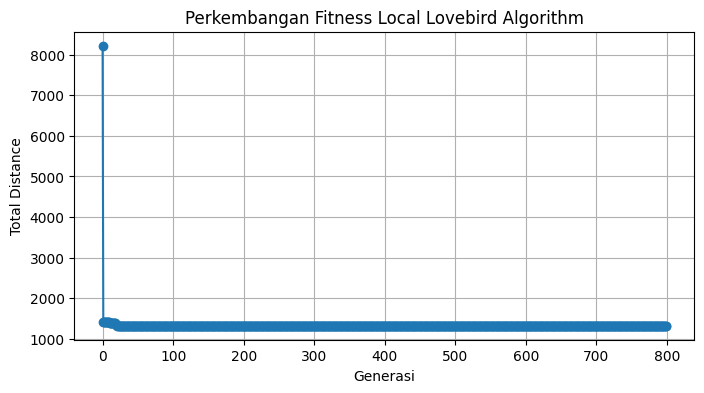

In [71]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_ll, marker='o')
plt.title("Perkembangan Fitness Local Lovebird Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

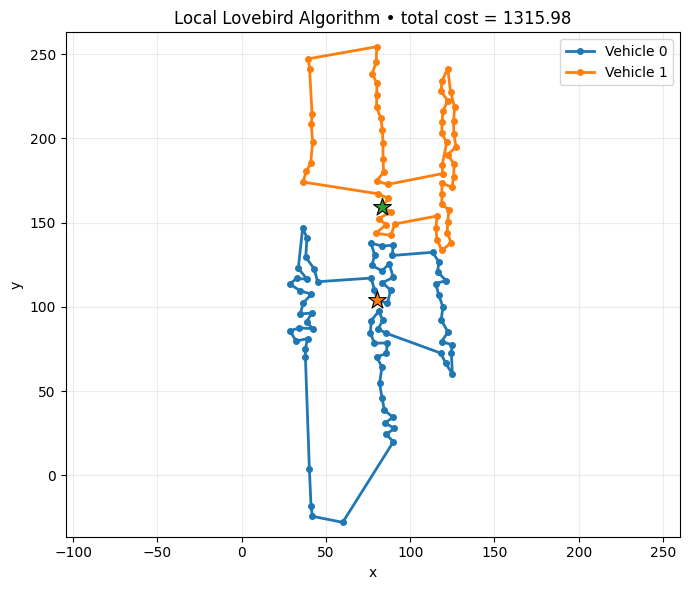

In [88]:
plot_vrp_routes(
    routes=[r + [r[0]] for r in best_sol_ll],       # hasil Lovebird per cluster
    coords=coords,
    node_index=node_index,
    starts=[r[0] for r in best_sol_ll],  # start = node pertama tiap cluster
    ends=None,
    show_ids=False,
    title=f"Local Lovebird Algorithm • total cost = {total_cost_l:.2f}",
    close_loop=True
)

# Iterated Lovebird Algorithm

In [63]:
def double_bridge(route, rng=None):
    """
    Double-bridge move klasik untuk TSP.
    Membutuhkan panjang minimal 8 agar meaningful.
    """
    if rng is None:
        rng = random

    L = len(route)
    if L < 8:
        return route[:]

    i1, i2, i3, i4 = sorted(rng.sample(range(L), 4))

    A = route[:i1]
    B = route[i1:i2]
    C = route[i2:i3]
    D = route[i3:i4]
    E = route[i4:]

    # versi klasik: A + C + B + D + E
    return A + C + B + D + E

In [64]:
def or_opt_intra(route, k=2, dist=None, index=None, rng=None):
    """
    OR-opt intra-route untuk TSP circular.
    Memindahkan blok berukuran k ke posisi terbaik.
    O(L) insertion scan.
    """
    if rng is None:
        rng = random
    if dist is None:
        dist = dist_matrix
    if index is None:
        index = node_index

    L = len(route)
    if L < k + 2:
        return route[:]

    i = rng.randint(0, L - k - 1)

    a = route[i]
    b = route[i + k - 1]
    p = route[i - 1] if i > 0 else route[-1]
    n = route[i + k] if (i + k) < L else route[0]

    block    = route[i:i+k]
    residual = route[:i] + route[i+k:]
    M        = len(residual)

    # biaya melepas block dari tempat lama
    remove_cost = (
        - dist[index[p], index[a]]
        - dist[index[b], index[n]]
        + dist[index[p], index[n]]
    )

    best_j = None
    best_delta = 0.0

    for j in range(M):
        x = residual[j - 1] if j > 0 else residual[-1]
        y = residual[j]

        insert_cost = (
            - dist[index[x], index[y]]
            + dist[index[x], index[a]]
            + dist[index[b], index[y]]
        )

        delta = remove_cost + insert_cost
        if delta < best_delta:
            best_delta = delta
            best_j = j

    if best_j is None:
        return route[:]

    return residual[:best_j] + block + residual[best_j:]

In [65]:
def perturb_multi_simple(
    solution,
    p_intra=0.95,
    prefer_k3=False,
    max_block=6,
    allow_inter_cluster=False,
    dist=None,
    index=None,
    rng=None,
):
    """
    Perturbasi multi-route:
    - mayoritas OR-opt intra
    - opsional inter-route swap
    - strong shake (double-bridge)
    - partial-scramble
    """

    if dist is None:
        dist = dist_matrix
    if index is None:
        index = node_index
    if rng is None:
        rng = random

    sol = [r[:] for r in solution]
    rrand = rng.random

    # --- 1) mayoritas intra OR-opt ---
    did_intra = False
    if rrand() < p_intra:
        cand = [i for i, r in enumerate(sol) if len(r) >= 5]
        if cand:
            v = rng.choice(cand)
            k = 3 if (prefer_k3 and len(sol[v]) >= 5) else 2
            sol[v] = or_opt_intra(sol[v], k=k, dist=dist, index=index, rng=rng)
            did_intra = True

    # --- 2) inter-cluster swap (opsional) ---
    if (not did_intra) and allow_inter_cluster:
        nz = [i for i, r in enumerate(sol) if len(r) > 0]
        if len(nz) >= 2:
            a, b = rng.sample(nz, 2)
            ia = rng.randrange(len(sol[a]))
            ib = rng.randrange(len(sol[b]))
            sol[a][ia], sol[b][ib] = sol[b][ib], sol[a][ia]

    # --- 3) strong shake (double-bridge) ---
    if prefer_k3 and sol:
        v2 = max(range(len(sol)), key=lambda t: len(sol[t]))
        if len(sol[v2]) >= 8 and rrand() < 0.07:
            sol[v2] = double_bridge(sol[v2], rng=rng)

    # --- 4) small scramble ---
    if rrand() < 0.05 and sol:
        v2 = max(range(len(sol)), key=lambda t: len(sol[t]))
        L = len(sol[v2])
        if L >= 6:
            m = rng.randint(3, min(max_block, L - 1))
            i = rng.randint(0, L - m)
            sub = sol[v2][i:i+m]
            rng.shuffle(sub)
            sol[v2] = sol[v2][:i] + sub + sol[v2][i+m:]

    return sol

In [74]:
def iterated_lovebird(
    max_iter=30,
    local_gen=120,
    clusters=None,              # list of list node IDs per kluster
    labels=None, nodes=None,    # alternatif input: labels dari KMeans + urutan nodes
    initial_solution=None,      # seed awal (list of routes)
    patience=3,
    seed=None,
    budget_s=None,
    allow_inter_cluster=False   # default: hormati kluster
):
    if seed is not None:
        random.seed(seed)

    # --- solusi awal, sama seperti versi sebelum refactor ---
    def _init_solution_from_inputs():
        if clusters is not None:
            cur = [r[:] for r in clusters if len(r) > 0]
            return cur if cur else [[]]

        elif (labels is not None) and (nodes is not None):
            lab_arr = np.asarray(labels)
            K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
            tmp = {c: [] for c in range(K)}
            for n, l in zip(nodes, lab_arr):
                tmp[int(l)].append(n)
            cur = [tmp[c] for c in range(K) if tmp[c]]
            return cur if cur else [[]]

        elif initial_solution is not None:
            cur = [r[:] for r in initial_solution if len(r) > 0]
            return cur if cur else [[]]

        else:
            if nodes is None:
                raise ValueError(
                    "nodes harus diisi jika tidak memberikan clusters / labels / initial_solution"
                )
            ids_copy = list(nodes)
            random.shuffle(ids_copy)
            return [ids_copy]  # fallback: satu rute

    ls = lovebird_local_search  # alias

    SAFETY = 0.05
    t_start = time.perf_counter()
    deadline = (t_start + budget_s) if budget_s is not None else None

    def time_left():
        return None if deadline is None else max(0.0, deadline - time.perf_counter())
    
    # --- LS awal ---
    start_solution = _init_solution_from_inputs()

    rem = time_left()
    if rem is not None and rem <= SAFETY:
        per_cluster_costs = [total_distance(r) for r in start_solution]
        total_cost = float(sum(per_cluster_costs))
        return start_solution, total_cost, [total_cost], per_cluster_costs

    best_sol, best_cost, _hist0, _ = ls(
        max_iterations=local_gen,          # ⬅️ FIX: sebelumnya maxLoop=local_gen
        clusters=start_solution,
        time_budget=(rem - SAFETY) if rem is not None else None
    )

    history = [best_cost]
    no_improve = 0

    # --- ILS loop ---
    for _ in range(max_iter):
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        prefer_k3 = (no_improve >= patience)
        max_block = 6 + 2 * (no_improve // patience)

        perturbed = perturb_multi_simple(
            best_sol,
            p_intra=0.9,
            prefer_k3=prefer_k3,
            max_block=max_block,
            allow_inter_cluster=allow_inter_cluster
        )

        for i, r in enumerate(perturbed, 1):
            if len(r) != len(set(r)):
                print(f"[DEBUG] DUPLIKAT SETELAH PERTURB di kluster {i}: len={len(r)}, unique={len(set(r))}")


        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        imp_sol, imp_cost, _, _ = ls(
            max_iterations=local_gen,      # ⬅️ FIX di sini juga
            clusters=perturbed,
            time_budget=(rem - SAFETY) if rem is not None else None
        )

        for i, r in enumerate(imp_sol, 1):
            if len(r) != len(set(r)):
                print(f"[DEBUG] DUPLIKAT SETELAH LS di kluster {i}: len={len(r)}, unique={len(set(r))}")


        if imp_cost < best_cost - 1e-9:
            best_sol = [r[:] for r in imp_sol]
            best_cost = float(imp_cost)
            no_improve = 0
        else:
            no_improve += 1

        # hard restart kecil
        if no_improve >= 2 * patience:
            rem = time_left()
            if rem is None or rem > SAFETY + 0.1:
                strong = perturb_multi_simple(
                    best_sol,
                    p_intra=0.3,
                    prefer_k3=True,
                    max_block=12,
                    allow_inter_cluster=allow_inter_cluster
                )

                rem = time_left()
                if rem is not None and rem <= SAFETY:
                    break

                best_sol2, best_cost2, _, _ = ls(
                    max_iterations=local_gen,  # ⬅️ dan di sini
                    clusters=strong,
                    time_budget=(rem - SAFETY) if rem is not None else None
                )
                if best_cost2 < best_cost - 1e-9:
                    best_sol = [r[:] for r in best_sol2]
                    best_cost = float(best_cost2)
                    no_improve = 0

        history.append(best_cost)

    per_cluster_costs = [total_distance(r) for r in best_sol]
    best_cost = float(sum(per_cluster_costs))

    return best_sol, best_cost, history, per_cluster_costs

In [82]:
best_sol_il, best_cost_il, hist_il, per_costs_il = iterated_lovebird(
    max_iter=20, local_gen=20,
    labels=labels, nodes=nodes,
    budget_s=10.0
)

print("Biaya per kluster:", per_costs_il)
print("Total biaya (best_cost dari ILS):", best_cost_il)

for i, r in enumerate(best_sol_il, 1):
    print(f"Rute kluster {i} (|r|={len(r)}): {r}")

Biaya per kluster: [734.3665406409532, 580.6937510112629]
Total biaya (best_cost dari ILS): 1315.0602916522162
Rute kluster 1 (|r|=75): [67, 123, 43, 50, 101, 130, 1, 71, 55, 30, 115, 47, 88, 77, 20, 76, 60, 16, 85, 6, 41, 116, 69, 84, 8, 135, 53, 38, 78, 18, 58, 128, 108, 44, 114, 90, 3, 82, 125, 59, 27, 51, 80, 10, 117, 52, 29, 54, 110, 106, 15, 93, 62, 132, 112, 96, 37, 81, 40, 72, 34, 107, 23, 63, 111, 133, 95, 4, 42, 103, 11, 26, 124, 21, 129]
Rute kluster 2 (|r|=60): [105, 24, 94, 49, 9, 99, 56, 17, 35, 79, 22, 86, 7, 65, 83, 102, 14, 134, 57, 122, 28, 87, 121, 109, 73, 68, 118, 19, 46, 45, 61, 126, 100, 33, 89, 13, 131, 98, 119, 75, 48, 2, 127, 66, 32, 92, 12, 70, 120, 25, 64, 113, 104, 39, 74, 31, 97, 5, 91, 36]


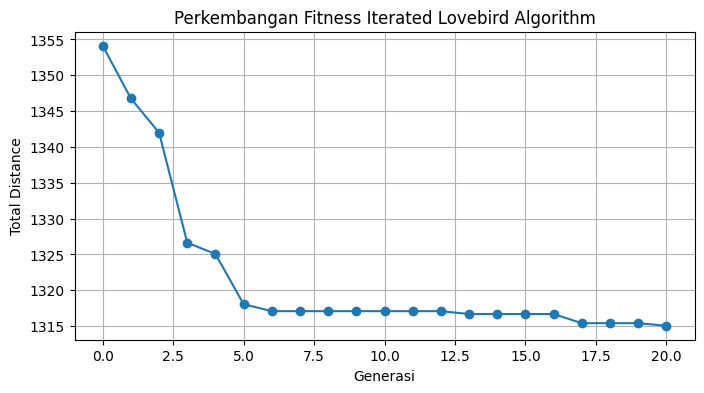

In [84]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_il, marker='o')
plt.title("Perkembangan Fitness Iterated Lovebird Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

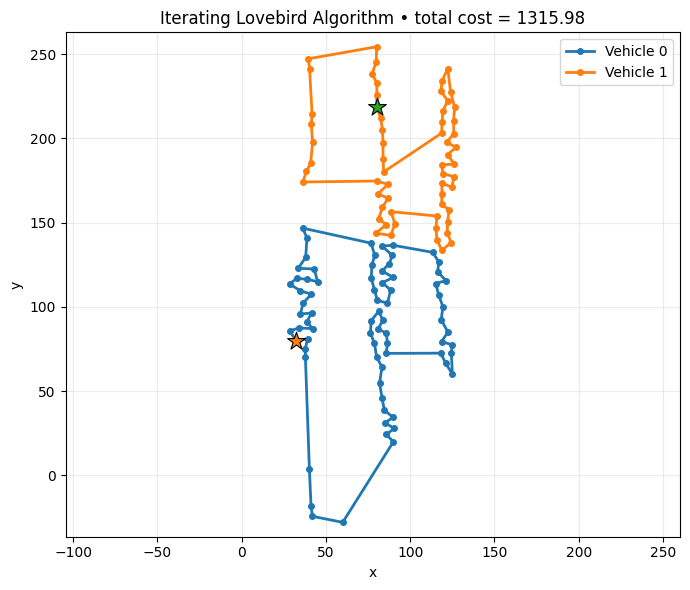

In [95]:
plot_vrp_routes(
    routes=[r + [r[0]] for r in best_sol_il],       # hasil Lovebird per cluster
    coords=coords,
    node_index=node_index,
    starts=[r[0] for r in best_sol_il],  # start = node pertama tiap cluster
    ends=None,
    show_ids=False,
    title=f"Iterating Lovebird Algorithm • total cost = {total_cost_l:.2f}",
    close_loop=True
)

# Hyper Iterated Lovebird Algorithm

In [89]:
def hyper_iterated_lovebird(
    max_iter=10,
    local_gen_shallow=8,
    local_gen_deep=30,
    deep_every=3,
    patience=2,
    initial_solution=None,
    p_intra=0.95,
    base_max_block=6,
    budget_s=None,
    seed=None,
    clusters=None,
    labels=None, nodes=None,
    allow_inter_cluster=False
):
    if seed is not None:
        random.seed(seed)

    def _init_solution_from_inputs():
        if clusters is not None:
            cur = [r[:] for r in clusters if len(r) > 0]
            return cur if cur else [[]]

        elif (labels is not None) and (nodes is not None):
            lab_arr = np.asarray(labels)
            K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
            tmp = {c: [] for c in range(K)}
            for n, l in zip(nodes, lab_arr):
                tmp[int(l)].append(n)
            cur = [tmp[c] for c in range(K) if tmp[c]]
            return cur if cur else [[]]

        elif initial_solution is not None:
            cur = [r[:] for r in initial_solution if len(r) > 0]
            return cur if cur else [[]]

        else:
            if nodes is None:
                raise ValueError("nodes harus diisi jika tidak memberikan clusters/labels/initial_solution")
            ids_copy = list(nodes)
            random.shuffle(ids_copy)
            return [ids_copy]

    t_start = time.perf_counter()
    deadline = (t_start + budget_s) if budget_s is not None else None
    SAFETY = 0.05

    def time_left():
        return None if deadline is None else max(0.0, deadline - time.perf_counter())

    start_solution = _init_solution_from_inputs()

    rem = time_left()
    if rem is not None and rem <= SAFETY:
        per_cluster_costs = [total_distance(r) for r in start_solution]
        total_cost = float(sum(per_cluster_costs))
        return start_solution, total_cost, [total_cost], per_cluster_costs

    sol0, cost0, _, _ = lovebird_local_search(
        max_iterations=max(local_gen_deep, 10),
        clusters=start_solution,
        time_budget=(rem - SAFETY) if rem is not None else None
    )

    best_sol, best_cost = sol0, cost0
    history = [best_cost]
    no_improve = 0

    elite = [(best_cost, [r[:] for r in best_sol])]
    ELITE_K = 3

    for it in range(1, max_iter + 1):
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        prefer_k3 = (no_improve >= patience)
        max_block = base_max_block + 2 * (no_improve // patience)

        perturbed = perturb_multi_simple(
            best_sol,
            p_intra=p_intra,
            prefer_k3=prefer_k3,
            max_block=max_block,
            allow_inter_cluster=allow_inter_cluster
        )

        def _hamming_routes(A, B):
            diff = 0
            for ra, rb in zip(A, B):
                m = min(len(ra), len(rb))
                for i in range(m):
                    if ra[i] != rb[i]:
                        diff += 1
                diff += abs(len(ra) - len(rb))
            return diff

        total_n = sum(len(r) for r in best_sol)
        BASE_FRAC  = 0.05
        EARLY_FRAC = 0.08
        MID_FRAC   = 0.08
        MIN_DIFF = max(8, int(BASE_FRAC * total_n))
        plateau_after = max(3, 2 * patience)

        diff = _hamming_routes(perturbed, best_sol)
        need = MIN_DIFF
        if it <= 2:
            need = max(need, int(EARLY_FRAC * total_n))
        elif no_improve >= plateau_after:
            need = max(need, int(MID_FRAC * total_n))

        if diff < need:
            perturbed = perturb_multi_simple(
                best_sol,
                p_intra=max(0.6, p_intra - 0.2),
                prefer_k3=True,
                max_block=min(12, base_max_block + 2),
                allow_inter_cluster=allow_inter_cluster
            )

        use_deep = (it % deep_every == 0) or (no_improve >= patience)
        depth = local_gen_deep if use_deep else local_gen_shallow

        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        FINISHER_TAIL = 1.0
        remaining_iter = max(1, max_iter - it + 1)
        MIN_BUDGET_SHALLOW = 0.50
        MIN_BUDGET_DEEP    = 1.25

        if rem is None:
            ls_budget = None
        else:
            usable = max(0.0, rem - max(SAFETY, FINISHER_TAIL))
            slot = usable / remaining_iter
            slot *= (1.6 if use_deep else 1.0)
            floor_need = MIN_BUDGET_DEEP if use_deep else MIN_BUDGET_SHALLOW
            slot = max(slot, floor_need)
            ls_budget = max(0.0, min(slot, usable - 0.01))

        sol, cost, _, _ = lovebird_local_search(
            max_iterations=depth,
            clusters=perturbed,
            time_budget=ls_budget
        )

        if all(abs(cost - c0) > 1e-7 for c0, _ in elite):
            elite.append((cost, [r[:] for r in sol]))
            elite.sort(key=lambda x: x[0])
            if len(elite) > ELITE_K:
                elite.pop()

        if cost < best_cost - 1e-9:
            best_sol, best_cost = sol, cost
            no_improve = 0
        else:
            no_improve += 1
            rem = time_left()
            if (no_improve >= 2 * patience) and (rem is None or rem > SAFETY + 0.1):
                strong = perturb_multi_simple(
                    best_sol,
                    p_intra=0.6,
                    prefer_k3=True,
                    max_block=min(12, base_max_block + 4),
                    allow_inter_cluster=allow_inter_cluster
                )
                rem = time_left()
                if rem is not None and rem <= SAFETY:
                    break
                sol2, cost2, _, _ = lovebird_local_search(
                    max_iterations=local_gen_deep,
                    clusters=strong,
                    time_budget=(rem - SAFETY) if rem is not None else None
                )
                if cost2 < best_cost - 1e-9:
                    best_sol, best_cost = sol2, cost2
                    no_improve = 0

        history.append(best_cost)

    # --- konsisten dengan algoritma lain ---
    per_cluster_costs = [total_distance(r) for r in best_sol]
    total_cost = float(sum(per_cluster_costs))

    return best_sol, total_cost, history, per_cluster_costs

In [91]:
best_sol_ail, best_cost_ail, hist_ail, per_costs_ail = hyper_iterated_lovebird(
    max_iter=20, local_gen_shallow=10, local_gen_deep=40, deep_every=3,
    labels=labels, nodes=nodes, budget_s=20.0,
    allow_inter_cluster=False  # set True kalau mau izinkan cross-move saat perturb
)

# ringkasan hasil
print("Biaya per kluster:", per_costs_ail)
print("Total biaya:", sum(per_costs_ail))
for i, r in enumerate(best_sol_ail, 1):
    print(f"Rute kluster {i} (|r|={len(r)}): {r}")

Biaya per kluster: [732.414114184426, 574.8384199557248]
Total biaya: 1307.2525341401508
Rute kluster 1 (|r|=75): [8, 84, 69, 116, 41, 108, 6, 85, 16, 60, 76, 20, 77, 88, 47, 115, 30, 55, 71, 1, 130, 101, 50, 129, 43, 123, 67, 21, 124, 26, 11, 103, 42, 4, 95, 133, 111, 63, 23, 107, 34, 72, 40, 81, 37, 96, 112, 132, 62, 93, 15, 106, 110, 54, 29, 52, 117, 10, 80, 51, 27, 59, 125, 82, 3, 90, 114, 44, 128, 58, 18, 78, 38, 53, 135]
Rute kluster 2 (|r|=60): [14, 65, 7, 86, 22, 79, 35, 17, 56, 99, 9, 49, 94, 24, 105, 36, 91, 5, 97, 31, 83, 102, 13, 119, 75, 2, 66, 74, 39, 104, 113, 64, 25, 120, 70, 12, 92, 32, 127, 48, 98, 131, 89, 33, 100, 126, 61, 45, 46, 19, 118, 68, 109, 28, 121, 87, 122, 73, 57, 134]


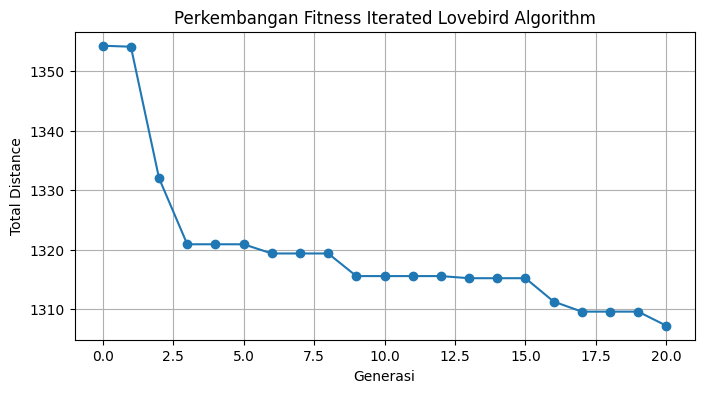

In [93]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_ail, marker='o')
plt.title("Perkembangan Fitness Iterated Lovebird Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

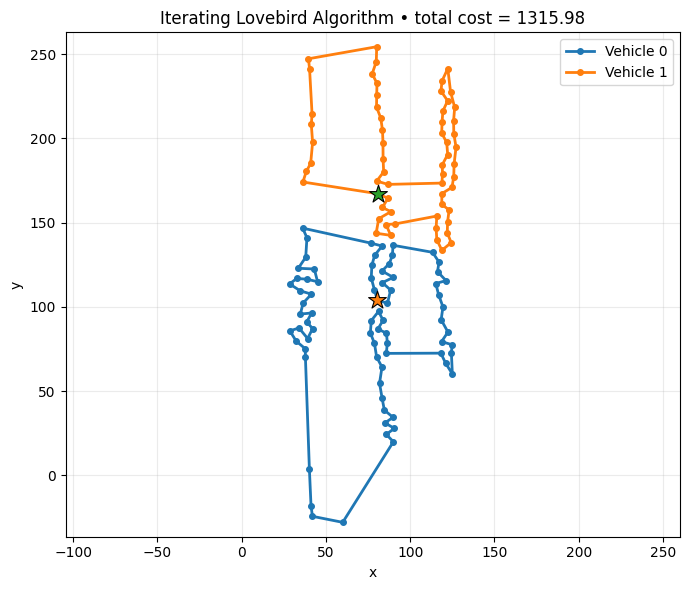

In [94]:
plot_vrp_routes(
    routes=[r + [r[0]] for r in best_sol_ail],       # hasil Lovebird per cluster
    coords=coords,
    node_index=node_index,
    starts=[r[0] for r in best_sol_ail],  # start = node pertama tiap cluster
    ends=None,
    show_ids=False,
    title=f"Iterating Lovebird Algorithm • total cost = {total_cost_l:.2f}",
    close_loop=True
)

# Distance Counter

In [96]:
sample_route = [8, 84, 69, 116, 41, 108, 6, 85, 16, 60, 20, 77, 88, 76, 47, 115, 30, 55, 71, 1, 130, 101, 50, 43, 123, 67, 129, 21, 124, 26, 11, 103, 42, 4, 95, 133, 111, 63, 23, 107, 34, 72, 40, 81, 37, 96, 112, 132, 62, 93, 15, 106, 110, 54, 29, 52, 117, 10, 80, 51, 27, 59, 125, 82, 3, 90, 114, 44, 128, 58, 18, 78, 38, 53, 135, 8]
distance = total_distance(sample_route)
print("Total distance:", distance)

Total distance: 731.5083748497522


# Testing

In [97]:
def _choose_starts_from_input(start_sol, labels, nodes, seed=None):
    """
    Pilih start per kluster:
    - Kalau start_sol (list-of-routes) ada: ambil elemen pertama tiap rute.
    - Else: random per kluster berdasarkan labels.
    """
    rng = random.Random(seed)
    if start_sol is not None and len(start_sol) > 0:
        return [r[0] for r in start_sol]  # asumsikan tiap rute non-empty

    K = int(max(labels)) + 1 if len(labels) > 0 else 0
    buckets = {c: [] for c in range(K)}
    for n, l in zip(nodes, labels):
        buckets[int(l)].append(n)
    # random start per kluster
    return [rng.choice(buckets[c]) for c in range(K)]

def _ortools_solver_wrapper(
    nodes,
    labels,
    starts_ids,
    timeout_s=60,
    use_precomputed=True,
    ends_ids=None,
    first_strategy="PATH_CHEAPEST_ARC",
    metaheuristic="GUIDED_LOCAL_SEARCH",
    scale=SCALE,
):
    """
    Bungkus solve_vrp_clustered agar return-nya kompatibel dengan timed_call:
    (sol, cost, hist)

    - sol  : list rute (tiap rute SUDAH termasuk node end di elemen terakhir)
    - cost : total_cost_float (unscaled)
    - hist : dict ringkas, saat ini hanya {"per_costs": per_vehicle_costs}
    """
    routes, per_costs, total_cost = solve_vrp_clustered(
        nodes=nodes,
        labels=labels,
        start_ids=starts_ids,
        end_ids=ends_ids,
        timeout_s=timeout_s,
        first_strategy=first_strategy,
        metaheuristic=metaheuristic,
        use_precomputed=use_precomputed,
        scale=scale,
    )
    return routes, float(total_cost), {"per_costs": per_costs}

In [100]:
# =========[ Testing Harness: cluster-aware ]=========
def _build_start_solution(clusters=None, labels=None, nodes=None):
    """
    Balikin list-of-routes sesuai input:
    - clusters: langsung dipakai
    - labels+nodes: disusun per label, urut sesuai nodes
    - kalau dua-duanya None -> None (biar solver fallback)
    """
    if clusters is not None:
        return [r[:] for r in clusters if len(r) > 0]
    if (labels is not None) and (nodes is not None):
        lab = np.asarray(labels)
        K = int(lab.max()) + 1 if lab.size > 0 else 0
        tmp = {c: [] for c in range(K)}
        for n, l in zip(nodes, lab):
            tmp[int(l)].append(n)
        return [tmp[c] for c in range(K) if tmp[c]]
    return None


def timed_call(fn, *args, **kwargs):
    """
    Jalankan solver dan normalisasi hasilnya jadi (sol, cost, hist, dt).

    Solver boleh return:
      - (sol, cost)
      - (sol, cost, hist)
      - (sol, cost, hist, extra)    # untuk kasus Lovebird: extra = per_cluster_costs
    """
    t0 = time.perf_counter()
    ret = fn(*args, **kwargs)
    dt = time.perf_counter() - t0

    if not isinstance(ret, tuple):
        raise ValueError("Solver must return a tuple.")

    if len(ret) == 2:
        sol, cost = ret
        hist = None

    elif len(ret) == 3:
        sol, cost, hist = ret

    elif len(ret) == 4:
        sol, cost, hist, _extra = ret
        # Di sini:
        #  - untuk Lovebird: hist = history (list cost), _extra = per_cluster_costs (diabaikan)
        #  - untuk pola lain, kalau mau, bisa di-handle lebih detail nanti
        # Testing harness tidak pakai hist, jadi cukup simpan hist saja.

    else:
        raise ValueError(f"Unexpected solver return length: {len(ret)}")

    return sol, float(cost), hist, float(dt)


def _stat(x):
    x = np.asarray(x, dtype=float)
    return np.mean(x), np.std(x, ddof=1) if len(x) > 1 else 0.0, np.median(x), np.min(x), np.max(x)


def experiment_boxplot_time(
    N=20,
    # input kluster (pilih salah satu)
    clusters=None,
    labels=None,
    nodes=None,
    # budget default untuk solver berbasis waktu
    budget_s=20.0,
    # pilih solver mana yang mau dites (True/False)
    run_ortools=False,   # OR-Tools baseline
    run_ils=False,
    run_hyper=True,
    # seed kontrol (None = random)
    base_seed=None
):
    """
    Jalankan N percobaan, masing-masing dengan seed berbeda (berdasar base_seed).
    Setidaknya salah satu dari run_local/run_ils/run_hyper = True.
    Bisa kirim clusters atau labels+nodes.
    """
    if not (run_ortools or run_ils or run_hyper):
        raise ValueError("Setidaknya satu solver harus diaktifkan.")

    start_sol = _build_start_solution(clusters=clusters, labels=labels, nodes=nodes)

    results, times = {}, {}
    if run_ortools:
        results["Ortools"] = [];     times["Ortools"] = []
    if run_ils:
        results["ILS"] = [];         times["ILS"] = []
    if run_hyper:
        results["Hyper-ILS"] = [];   times["Hyper-ILS"] = []

    # ========== LOOP EKSPERIMEN ==========
    for trial in range(N):
        seed = (None if base_seed is None else (base_seed + trial))
        if seed is not None:
            random.seed(seed)

        # ---- OR-Tools (cluster-aware) ----
        if run_ortools:
            # Pilih starts dari input (kalau ada clusters/labels), atau acak per kluster
            starts_ids = _choose_starts_from_input(start_sol, labels, nodes, seed=seed)
            # Biasanya round-trip → ends = starts. Kalau mau path berbeda, set sendiri.
            ends_ids = starts_ids

            # Panggil via timed_call agar waktu kebaca
            sol, cst, hist, dt = timed_call(
                _ortools_solver_wrapper,
                nodes, labels, starts_ids,
                timeout_s=budget_s,  # konsisten pakai budget_s untuk fair comparison
                use_precomputed=True,
                ends_ids=ends_ids,
                first_strategy="PATH_CHEAPEST_ARC",
                metaheuristic="GUIDED_LOCAL_SEARCH"
            )
            results["Ortools"].append(cst); times["Ortools"].append(dt)

        # ---- Iterated Lovebird (cluster-aware) ----
        if run_ils:
            kwargs_ils = {}
            if start_sol is not None:
                kwargs_ils.update(dict(clusters=start_sol))
            else:
                kwargs_ils.update(dict(initial_solution=None))

            sol, cst, _, dt = timed_call(
                iterated_lovebird,
                max_iter=20, local_gen=50, patience=2,
                budget_s=budget_s,
                seed=seed,
                allow_inter_cluster=False,   # set True jika ingin izinkan cross-move
                **kwargs_ils
            )
            results["ILS"].append(cst); times["ILS"].append(dt)

        # ---- Hyper-ILS (cluster-aware) ----
        if run_hyper:
            kwargs_hil = {}
            if start_sol is not None:
                kwargs_hil.update(dict(clusters=start_sol))
            else:
                kwargs_hil.update(dict(initial_solution=None))

            sol, cst, _, dt = timed_call(
                hyper_iterated_lovebird,
                max_iter=30,
                local_gen_shallow=6, local_gen_deep=30,
                deep_every=4, patience=1,
                p_intra=0.99, base_max_block=6,
                budget_s=budget_s, seed=seed,
                allow_inter_cluster=False,   # set True jika ingin cross-move saat perturb
                **kwargs_hil
            )
            results["Hyper-ILS"].append(cst); times["Hyper-ILS"].append(dt)

    # ---- Ringkasan ----
    print("\n=== RINGKASAN COST & WAKTU (mean±std; median; min–max) ===")
    for name in results:
        if len(results[name]) == 0:
            print(f"{name:10}: (tidak ada data)")
            continue
        m, s, med, mn, mx = _stat(results[name])
        tm, ts, _, _, _ = _stat(times[name]) if len(times[name]) > 0 else (0,0,0,0,0)
        print(f"{name:10}: cost {m:.2f}±{s:.2f} (med {med:.2f}) [{mn:.2f}, {mx:.2f}] | "
              f"time {tm:.2f}±{ts:.2f}s")

    return results, times

In [101]:
res, tms = experiment_boxplot_time(
    N=20,
    labels=labels, nodes=nodes,
    budget_s=20.0,
    run_ortools=True,
    run_ils=True,
    run_hyper=True,
    base_seed=None
)


=== RINGKASAN COST & WAKTU (mean±std; median; min–max) ===
Ortools   : cost 1312.12±8.74 (med 1309.28) [1309.28, 1337.68] | time 20.01±0.00s
ILS       : cost 1311.14±3.28 (med 1310.51) [1305.65, 1318.88] | time 15.86±2.21s
Hyper-ILS : cost 1310.18±3.03 (med 1309.87) [1305.65, 1315.42] | time 14.32±2.13s


# Tuning

In [33]:
# ---------------------------------------------------------
# UTIL
# ---------------------------------------------------------
def cvar20(costs):
    k = max(1, int(0.2*len(costs)))
    return float(np.sort(costs)[:k].mean())

# di eval_config_hils: return juga "cvar20"

def timed_call(fn, *args, **kwargs):
    t0 = time.perf_counter()
    sol, cost, hist = fn(*args, **kwargs)
    dt = time.perf_counter() - t0
    return sol, cost, hist, dt

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

def tour_cost(route):
    if not route: return 0.0
    s = 0.0
    for i in range(len(route) - 1):
        s += D[idx[route[i]]][idx[route[i+1]]]
    s += D[idx[route[-1]]][idx[route[0]]]
    return s

def multi_tour_cost(routes):
    return sum(tour_cost(r) for r in routes if len(r) >= 2)

# ---------------------------------------------------------
# EVALUATOR: jalankan beberapa replika utk 1 konfigurasi
# ---------------------------------------------------------
def eval_config_hils(cfg, replicates=5, base_seed=12345,
                     budget_s=12, verbose=False):
    """
    Return ringkasan + detail per-replicate:
      - all_costs, all_times
      - replicates: list of dict {run, seed, cost, time}
      - statistik ringkas (mean, median, q1, q3, std, cvar20, dst.)
    """
    seeds = [base_seed + 1000*r for r in range(replicates)]  # CRN: seed konsisten
    costs, times, reps = [], [], []

    for r in range(replicates):
        _, cost, _, dt = timed_call(
            hyper_iterated_lovebird,
            max_iter=cfg["max_iter"],
            local_gen_shallow=cfg["local_gen_shallow"],
            local_gen_deep=cfg["local_gen_deep"],
            deep_every=cfg["deep_every"],
            patience=cfg["patience"],
            p_intra=cfg["p_intra"],
            base_max_block=cfg["base_max_block"],
            budget_s=budget_s,
            seed=seeds[r],
        )
        costs.append(cost)
        times.append(dt)
        reps.append({"run": r+1, "seed": seeds[r], "cost": float(cost), "time": float(dt)})
        if verbose:
            print(f"    replicate#{r+1} seed={seeds[r]}: cost={cost:.2f}, time={dt:.2f}s")

    arr  = np.array(costs, float)
    tarr = np.array(times, float)

    # statistik ringkas
    q1, q3 = np.percentile(arr, 25), np.percentile(arr, 75)
    out = {
        "cfg": cfg.copy(),
        "runs": replicates,
        "all_costs": [float(x) for x in arr.tolist()],
        "all_times": [float(x) for x in tarr.tolist()],
        "replicates": reps,                       # <— detail per replicate
        "best": float(arr.min()),
        "median": float(np.median(arr)),
        "mean": float(arr.mean()),
        "std": float(arr.std(ddof=1)) if replicates > 1 else 0.0,     # <— tambah std (buat ranking print)
        "q1": float(q1), "q3": float(q3),
        "cvar20": float(cvar20(arr)),                                   # <— CVaR20
        "t_mean": float(tarr.mean()),
        "t_std": float(tarr.std(ddof=1)) if replicates > 1 else 0.0,    # opsional, buat info waktu
    }
    return out

# ---------------------------------------------------------
# SAMPLER: random search di ruang parameter
# ---------------------------------------------------------
def sample_space():
    """Satu sampel konfigurasi Hyper-ILS.
       Jaga agar tidak berat tapi masih eksploratif."""
    return {
        "max_iter": random.choice([30]),           # budget akan membatasi totalnya
        "local_gen_shallow": random.choice([4, 5]),
        "local_gen_deep"   : random.choice([11, 13, 15]),
        "deep_every"       : random.choice([3, 4, 5]),
        "patience"         : random.choice([1, 2]),
        "p_intra"          : random.choice([0.95, 0.97, 0.98, 0.99]),
        "base_max_block"   : random.choice([6, 8, 10]),
    }

# ---------------------------------------------------------
# REFINER: generasi tetangga di sekitar config terbaik
# ---------------------------------------------------------
def neighbors(cfg):
    def clamp(x, lo, hi): 
        return max(lo, min(hi, x))

    ints = {}
    # ints["max_iter"] = sorted(set([clamp(cfg["max_iter"]+d, 8, 16) for d in [-2, -1, 0, +1, +2]]))
    ints["local_gen_shallow"] = sorted(set([clamp(cfg["local_gen_shallow"]+d, 3, 6) for d in [-1, 0, +1]]))
    ints["local_gen_deep"]    = sorted(set([clamp(cfg["local_gen_deep"]+d, 10, 16) for d in [-2, -1, 0, +1, +2]]))
    ints["deep_every"]        = sorted(set([clamp(cfg["deep_every"]+d, 2, 6) for d in [-1, 0, +1]]))
    ints["patience"]          = sorted(set([clamp(cfg["patience"]+d, 1, 3) for d in [-1, 0, +1]]))
    ints["base_max_block"]    = sorted(set([clamp(cfg["base_max_block"]+d, 4, 12) for d in [-2, 0, +2]]))

    ints["max_iter"] = sorted(set([clamp(cfg["max_iter"]+d, 20, 20) for d in [0]]))
    # ints["local_gen_shallow"] = sorted(set([clamp(cfg["local_gen_shallow"]+d, 3, 9) for d in [0]]))
    # ints["local_gen_deep"]    = sorted(set([clamp(cfg["local_gen_deep"]+d, 14, 26) for d in [0]]))
    # ints["deep_every"]        = sorted(set([clamp(cfg["deep_every"]+d, 2, 6) for d in [0]]))
    # ints["patience"]          = sorted(set([clamp(cfg["patience"]+d, 1, 3) for d in [0]]))
    # ints["base_max_block"]    = sorted(set([clamp(cfg["base_max_block"]+d, 4, 12) for d in [0]]))

    fp = sorted(set([round(x,3) for x in [
        cfg["p_intra"]-0.02, cfg["p_intra"]-0.01, cfg["p_intra"],
        cfg["p_intra"]+0.01, cfg["p_intra"]+0.02
    ] if 0.90 <= x <= 0.995]))

    # fp = sorted(set([round(x,3) for x in [
    #     cfg["p_intra"]
    # ] if 0.90 <= x <= 0.995]))

    neighs = []
    for mi in ints["max_iter"]:
        for lgs in ints["local_gen_shallow"]:
            for lgd in ints["local_gen_deep"]:
                for de in ints["deep_every"]:
                    for pa in ints["patience"]:
                        for pi in fp:
                            for bm in ints["base_max_block"]:
                                neighs.append({
                                    "max_iter": mi,
                                    "local_gen_shallow": lgs,
                                    "local_gen_deep": lgd,
                                    "deep_every": de,
                                    "patience": pa,
                                    "p_intra": float(pi),
                                    "base_max_block": bm
                                })
    # opsi: shuffle & subset biar nggak kebanyakan
    random.shuffle(neighs)
    return neighs[:40]  # batasi 40 kandidat terdekat

# ---------------------------------------------------------
# TUNER: random search + refine
# ---------------------------------------------------------
def tune_hyper_ils(
    trials_random=60,     # jumlah sampel random
    trials_refine=40,     # kandidat refine (dibatasi di neighbors())
    replicates=5,         # run per konfigurasi
    target_best=2012.0,   # stop dini jika sudah <= target
    budget_s=12,
    base_seed=12345,
    verbose=False
):
    all_results = []

    # ---- Phase 1: Random Search ----
    for t in range(trials_random):
        cfg = sample_space()
        res = eval_config_hils(cfg, replicates=replicates, base_seed=base_seed,
                               budget_s=budget_s, verbose=verbose)
        all_results.append(res)
        print(f"[RS {t+1}/{trials_random}] best={res['best']:.2f}  med={res['median']:.2f}  "
              f"time~{res['t_mean']:.2f}s  cfg={res['cfg']}")
        print("      costs :", ", ".join(f"{x:.2f}" for x in res["all_costs"]))
        print("      times :", ", ".join(f"{x:.2f}s" for x in res["all_times"]))
        if res["best"] <= target_best:
            print("Target tercapai pada random search.")
            break

    # pilih kandidat terbaik dari fase 1 (berdasar 'best', tie-break median)
    all_results.sort(key=lambda r: (r["best"], r["median"]))
    top = all_results[0]
    print("\n[Top setelah Random Search]")
    print(f"best={top['best']:.2f}  median={top['median']:.2f}  "
          f"time~{top['t_mean']:.2f}s cfg={top['cfg']}")

    # ---- Phase 2: Refine sekitar kandidat terbaik ----
    neighs = neighbors(top["cfg"])[:trials_refine]
    for t, cfg in enumerate(neighs, 1):
        res = eval_config_hils(cfg, replicates=replicates, base_seed=base_seed,
                               budget_s=budget_s, verbose=False)
        all_results.append(res)
        print(f"[RF {t}/{len(neighs)}] best={res['best']:.2f}  med={res['median']:.2f}  "
              f"time~{res['t_mean']:.2f}s  cfg={res['cfg']}")
        print("      costs :", ", ".join(f"{x:.2f}" for x in res["all_costs"]))
        print("      times :", ", ".join(f"{x:.2f}s" for x in res["all_times"]))

        for rep in res["replicates"]:
            print(f"        r{rep['run']:02d} seed={rep['seed']}: cost={rep['cost']:.2f} | {rep['time']:.2f}s")

        if res["best"] <= target_best:
            print("Target tercapai pada refine.")
            break

    # ---- Final ranking ----
    all_results.sort(key=lambda r: (r["best"], r["median"]))
    print("\n=== TOP 10 by Best (then Median) ===")
    for i, r in enumerate(all_results[:10], 1):
        print(f"{i:2d}) best={r['best']:.2f}  med={r['median']:.2f}  "
      f"cvar20={r['cvar20']:.2f}  mean={r['mean']:.2f}±{r['std']:.2f}  "
      f"time~{r['t_mean']:.2f}s  cfg={r['cfg']}")

    return all_results

In [34]:
# tetapkan budget & num_vehicles tetap
ALL = tune_hyper_ils(
    trials_random=60,     # kamu bisa mulai di 40 dulu kalau mau cepat
    trials_refine=40,
    replicates=5,         # 3–5 cukup; 5 lebih stabil
    target_best=1310,   # stop dini jika sudah kena target
    budget_s=20,          # JANGAN ubah
    base_seed=42,         # biar reproducible
    verbose=False
)

[RS 1/60] best=1216.61  med=1220.81  time~19.95s  cfg={'max_iter': 30, 'local_gen_shallow': 4, 'local_gen_deep': 15, 'deep_every': 3, 'patience': 1, 'p_intra': 0.95, 'base_max_block': 6}
      costs : 1246.00, 1216.61, 1219.82, 1220.81, 1247.99
      times : 19.96s, 19.95s, 19.96s, 19.96s, 19.95s
Target tercapai pada random search.

[Top setelah Random Search]
best=1216.61  median=1220.81  time~19.95s cfg={'max_iter': 30, 'local_gen_shallow': 4, 'local_gen_deep': 15, 'deep_every': 3, 'patience': 1, 'p_intra': 0.95, 'base_max_block': 6}
[RF 1/40] best=1222.16  med=1242.64  time~19.79s  cfg={'max_iter': 20, 'local_gen_shallow': 3, 'local_gen_deep': 14, 'deep_every': 2, 'patience': 2, 'p_intra': 0.97, 'base_max_block': 4}
      costs : 1242.64, 1222.16, 1248.50, 1228.86, 1243.76
      times : 19.16s, 19.95s, 19.95s, 19.95s, 19.95s
        r01 seed=42: cost=1242.64 | 19.16s
        r02 seed=1042: cost=1222.16 | 19.95s
        r03 seed=2042: cost=1248.50 | 19.95s
        r04 seed=3042: cost